<a href="https://colab.research.google.com/github/mnsharon/Projects/blob/main/Skin_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score

In [ ]:
import os
import glob
import zipfile
import random

#to get consistent results after multiple runs

In [ ]:
tf.random.set_seed(7)
np.random.seed(7)
random.seed(7)

# 0 for benign , 1 for malignant

In [ ]:
class_names = ["benign","malignant"]

In [ ]:
import urllib.request

# URLs for the dataset
train_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip"
valid_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip"
test_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip"

def download_and_extract_dataset():
    # Loop through each dataset URL
    for i, download_link in enumerate([valid_url, train_url, test_url]):
        temp_file = f"temp_{i}.zip"

        # Download the file
        print(f"Downloading {download_link}...")
        urllib.request.urlretrieve(download_link, temp_file)

        # Extract the file
        print(f"Extracting {download_link}...")
        with zipfile.ZipFile(temp_file, 'r') as z:
            z.extractall("data")

        # Remove the downloaded zip file
        os.remove(temp_file)
        print(f"Finished with {download_link}")

download_and_extract_dataset()

Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip...
Finished with https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip...
Finished with https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip...
Finished with https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip


In [ ]:
#preparing data
#generate csv

def generate_csv(folder , label2int):
  folder_name=os.path.basename(folder)
  labels = list(label2int)
  df = pd.DataFrame(columns=["filepath","label"])
  i=0
  for label in labels:
    print("Reading", os.path.join(folder,label, "*"))
    for filepath in glob.glob(os.path.join(folder, label, "*")):
      df.loc[i] = [filepath, label2int[label]]
      i += 1
  output_file=f"{folder_name}.csv"
  print("Saving",output_file)
  df.to_csv(output_file)

In [ ]:
generate_csv("data/train", {"nevus":0, "seborrheic_keratosis":0, "melanoma":1})
generate_csv("data/valid", {"nevus":0, "seborrheic_keratosis":0, "melanoma":1})
generate_csv("data/test", {"nevus":0, "seborrheic_keratosis":0, "melanoma":1})



Reading data/train/nevus/*
Reading data/train/seborrheic_keratosis/*
Reading data/train/melanoma/*
Saving train.csv
Reading data/valid/nevus/*
Reading data/valid/seborrheic_keratosis/*
Reading data/valid/melanoma/*
Saving valid.csv
Reading data/test/nevus/*
Reading data/test/seborrheic_keratosis/*
Reading data/test/melanoma/*
Saving test.csv


#Loading Data

In [ ]:
train_metadata_filename= "train.csv"
valid_metadata_filename="valid.csv"
#load csv files
df_train=pd.read_csv(train_metadata_filename)
df_valid=pd.read_csv(valid_metadata_filename)
n_training_samples=len(df_train)
n_validation_samples=len(df_valid)
print("Number of training samples: ",n_training_samples)
print("Number of validation samples: ",n_validation_samples)
train_ds= tf.data.Dataset.from_tensor_slices((df_train["filepath"],df_train["label"]))
valid_ds=tf.data.Dataset.from_tensor_slices((df_valid["filepath"], df_valid["label"]))

Number of training samples:  2000
Number of validation samples:  150


In [ ]:
def decode_img(img):
  #convert compressed string ot  a 3D unit8 tensor
  img=tf.image.decode_jpeg(img, channels=3)
  img=tf.image.convert_image_dtype(img,tf.float32)
  return tf.image.resize(img,[299,299])

In [ ]:
def process_path(filepath, label):
  img=tf.io.read_file(filepath)
  img=decode_img(img)
  return img, label

In [ ]:
valid_ds=valid_ds.map(process_path)
train_ds=train_ds.map(process_path)
for image, label in train_ds.take(1):
  print("Image shape:", image.shape)
  print("Label:",label.numpy())

Image shape: (299, 299, 3)
Label: 0


In [ ]:
#training parameters
batch_size =64
optimizer="rmsprop"

In [ ]:
# Define the prepare_for_training function with repeat and batch
def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds=ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

# Prepare the training and validation datasets
train_ds = prepare_for_training(train_ds, cache="train-cached-data", batch_size=batch_size)
valid_ds = prepare_for_training(valid_ds, cache="valid-cached-data", batch_size=batch_size)


In [ ]:
import os
if os.path.exists("valid-cached-data_0.lockfile"):
    os.remove("valid-cached-data_0.lockfile")



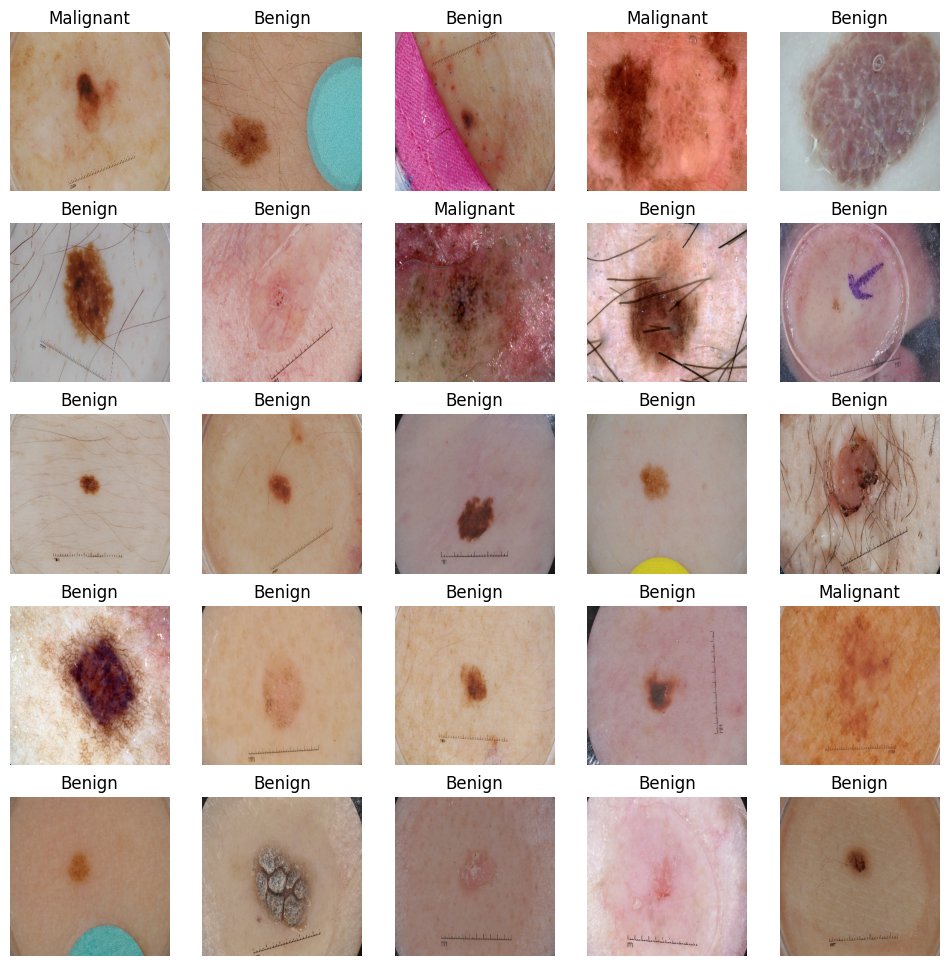

In [ ]:
batch=next(iter(valid_ds))
def show_batch(batch):
  plt.figure(figsize=(12,12))
  for n in range(25):
    ax=plt.subplot(5,5,n+1)
    plt.imshow(batch[0][n])
    plt.title(class_names[batch[1][n].numpy()].title())
    plt.axis('off')

show_batch(batch)

#Building Model


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Define the module URL for the feature vector model
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
hub_layer = hub.KerasLayer(module_url, trainable=False)

# Define the model using the Functional API, with a lambda wrapper to avoid conversion issues
inputs = tf.keras.Input(shape=(299, 299, 3))
x = tf.keras.layers.Lambda(lambda inputs: hub_layer(inputs))(inputs)  # Wrap in a Lambda layer
x = tf.keras.layers.Dense(128, activation="relu")(x)  # Additional Dense layer
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Build the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Check the model summary to ensure the layers are defined correctly
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 262,401 (1.00 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import os
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')  # Mixed precision

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

model_name = f"benign-vs-malignant_{batch_size}_{optimizer}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs", model_name))

modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join("logs", model_name + "_{val_loss:.3f}.keras"),
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    steps_per_epoch=(n_training_samples // batch_size) // 2,
    validation_steps=(n_validation_samples // batch_size) // 2,
    verbose=1,
    epochs=100,
    callbacks=[tensorboard, modelcheckpoint, early_stopping]
)


#evaluation
#load testing set


In [ ]:

test_metadata_filename="test.csv"
df_test=pd.read_csv(test_metadata_filename)
n_testing_samples=len(df_test)
print("Number of testing samples:",n_testing_samples)
test_ds= tf.data.Dataset.from_tensor_slices((df_test["filepath"],df_test["label"]))

def prepare_for_testing(ds,cache=True,shuffle_buffer_size=1000):
 if cache:
  if isinstance(cache,str):
	  ds=ds.cache(cache)
  else:
	  ds=ds.cache()
  ds=ds.shuffle(buffer_size=shuffle_buffer_size)
 return ds

test_ds=test_ds.map(process_path)
test_ds=prepare_for_testing(test_ds,cache="test-cached-data")

Number of testing samples: 600


In [ ]:
test_metadata_filename = "test.csv"
df_test = pd.read_csv(test_metadata_filename)

# Adjust file paths to ensure they are correct
base_test_path = "data/test"  # Correct base path for the test dataset
df_test["filepath"] = df_test["filepath"].apply(lambda x: os.path.join(base_test_path, x.split('/')[-2], x.split('/')[-1]))

# Check if all files exist
def check_file_exists(file_path):
    return os.path.isfile(file_path)

df_test["file_exists"] = df_test["filepath"].apply(check_file_exists)

# Count the number of valid testing samples
num_testing_samples = df_test["file_exists"].sum()
print(f"Number of valid testing samples: {num_testing_samples}")

# Optionally, print rows where the file does not exist for debugging
print(df_test[~df_test["file_exists"]])  # Print rows where the file does not exist

# Create the test dataset only if files exist
valid_files = df_test[df_test["file_exists"]]
test_ds = tf.data.Dataset.from_tensor_slices((valid_files["filepath"], valid_files["label"]))

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    return ds

# Define the process_path function
def process_path(file_path, label):
    # Add your image loading and processing logic here
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Adjust for the format of your images
    image = tf.image.resize(image, [224, 224])  # Resize to desired dimensions
    return image, label

# Map the processing function
test_ds = test_ds.map(process_path)
test_ds = prepare_for_testing(test_ds, cache="test-cached-data")

Number of valid testing samples: 600
Empty DataFrame
Columns: [Unnamed: 0, filepath, label, file_exists]
Index: []


In [ ]:
import numpy as np
import tensorflow as tf

# Convert testing set to NumPy array (do not do if set is too large)
y_test = np.zeros((num_testing_samples))
x_test = np.zeros((num_testing_samples, 299, 299, 3))

# Resize images before storing them in x_test
for i, (img, label) in enumerate(test_ds.take(num_testing_samples)):
    img_resized = tf.image.resize(img, [299, 299])  # Resize to (299, 299)
    x_test[i] = img_resized.numpy()  # Convert the tensor to numpy array
    y_test[i] = label.numpy()  # Call the numpy method

print("y_test.shape:", y_test.shape)


y_test.shape: (600,)


In [ ]:

print("Evaluating the model ...")
accuracy = model.evaluate(x_test, y_test, verbose=0)
print("     Accuracy: ", accuracy)

Evaluating the model ...
     Accuracy:  [0.624470591545105, 0.8050000071525574]
